<a href="https://colab.research.google.com/github/daje0601/covid19-dashboard/blob/main/covid19_vacine_distribution_plan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home exam 

###1.분석 요약 결과 보고

**Task1.**  
 당신에게 1백만 개의 백신이 있습니다. 각 나라별 확진자, 사망자, 회복자 데이터를 가지고 가장 과학적인 방법으로 백신을 분배하는 방법이 무엇인지 설명하세요(개인적인 의견은 삼가해주세요)

1)  Please define the objective clearly. "We would like to do good things" is not a clear definition. The objective has to be measurable.(목표설정)
 - 전세계에 백신을 무작위로 분배했을 경우 전체 사망률을 2.395% -> 2.393%로 낮아집니다. 
 - 데이터 분석을 통해 백신을 분배하여 2.393%보다 낮은 사망률이 나올 수 있도록 백신 지급국가와 지급 수량을 산정하도록 하게습니다. 
 - 지급받는 나라는 각 나라별 사망률과 회복률을 기준으로 선정하도록 하겠습니다. 
 - 백신을 분배 받을 나라가 선정되면, (확진자 수 * 사망률)을 기준으로 100만개의 백신을 순차적으로 지급하도록 하겠습니다. 
  
  
2)  What is the action item with numbers. What should we do with the vaccine? Be as specific as possible.(행동 계획)  
 - vaccine data 수집기간 : 20.01.22 ~ 21.07.10
 - 3개의 데이터 프레임으로 나누어진 확진자, 사망자, 회복자를 나라 이름을 index으로 한 데이터 프레임으로 제작합니다. 
 - 사망률과 회복되는 비율을 확인하기 위해 새로운 feature(death_rate, recover_rate)을 생성합니다. 
 - death_rate, recover_rate의 평균을 기준으로 데이터를 살펴보고, 사망률과 회복률의 Q1 계산합니다.(평균 값을 사용할 경우, 너무 많은 나라들이 선별되기 때문에 통계적으로 유의한 Q1 값을 기준으로 설정하였습니다.)   
  * 사망률 평균 : 2.2%
  * 회복률 평균 : 77%
  * 사망률 Q1 : 1.9% (np.round(0.022-(0.022*0.15), 3)
  * 회복률 Q1 : 65% (np.round(0.77-(0.77*0.15), 3))


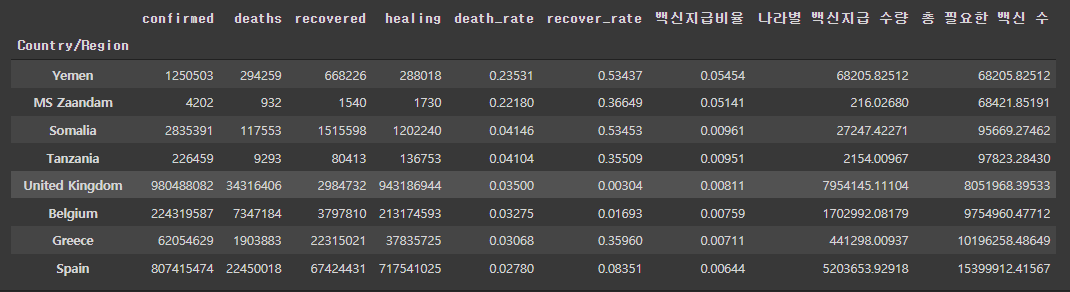

 - 사망률 Q1(1.9%) 보다 높고, 회복률 Q1(65%)보다 낮은 나라에 우선적으로 백신을 공급하는 기준을 세웠고, 이 기준에 맞추어 나라를 정렬한 결과가 위와 같습니다. 

 - 이 나라들의 사망률을 기준으로 하여 백신을 지급받을 비율을 산출하였습니다. 
 - 산출된 백신을 지급받을 비율 x 확진자 수를 곱하여서 지급할 백신의 수를 계산하였습니다. 
 - **계산한 결과, Yemen, MS Zaandam, Somalia, Tanzania, United Kingdom 나라가 선정되었습니다.**    
   
3) What is the expected impact of the vaccine? This expectation has to be numerical. "we hope the numbers will decrease dramatically" is not numerical.  
 - 전세계 사망률을 2.395% -> 2.393%로 낮아질 것으로 예측 됩니다. 
 - 실제 위 나라의 사망자들이 모두 백신을 맞고 살았다고 가정하고 사망률을 계산하면 2.392%로 0.001%가 더 사망률을 낮출 수 있었습니다. 
  
4) Can you predict confirmed/death/recovered in 3 months future? How accurate is your prediction?  
 - 해당 문제는 회귀 문제로써, mae, mse를 활용하여 딥러닝을 문제를 풀었습니다. 
 - confirmed model
  * MAE : 1.76
  * MSE : 7.13
 - deaths model
  * MAE : 1.13
  * MSE : 2.43
 - recover model
  * MAE : 2.08  
  * MSE : 5.22
 
  
데이터 출처 : https://github.com/CSSEGISandData/COVID-19
( 존 홉킨스 대학[CSSE] )

** 사전 가정사항 **

 - 당사가 보유하고 있는 백신은 아스트라제네카라고 가정합니다. 
 - 아스트라제네카 백신 1병으로 10명이 백신 접종을 할 수 있다고 가정합니다. (https://www.bbc.com/korean/news-56941222)
 - 아스트라제나카 백신은 2회 접종하여야함으로 총 50만명이 백신을 접종할 수 있다고 가정합니다. 
 - 2회 백신을 접종한 사람은 죽지 않는다고 가정합니다. 
 

#### Imports and Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import pycountry_convert as pc
from datetime import datetime, timedelta,date
import plotly.express as px

import tensorflow as tf

from keras import models
from tensorflow.keras.optimizers import RMSprop, Adam

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.5f}'.format

In [2]:
cd /content/drive/My Drive/data/covid

/content/drive/My Drive/data/covid


In [3]:
ls

confirmed_date_df.h5  recovered_date_df.h5
daily_report.csv      time_series_covid19_confirmed_global.csv
death_date_df.h5      time_series_covid19_deaths_global.csv
deaths_date_df.h5     time_series_covid19_recovered_global.csv


In [5]:
# 보내주신 kaggle 데이터를 살펴보다가 미국과 다른 나라가 결합된 global 데이터를 발견하여 해당 데이터를 활용하여 분석을 진행하도록 하겠습니다. 

confirmed_df = pd.read_csv("time_series_covid19_confirmed_global.csv")
deaths_df = pd.read_csv("time_series_covid19_deaths_global.csv")
recovered_df = pd.read_csv("time_series_covid19_recovered_global.csv")
report_df = pd.read_csv("daily_report.csv")

In [6]:
confirmed_df[confirmed_df["Country/Region"] == "United Kingdom"]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/

In [7]:
confirmed_df.shape, deaths_df.shape, recovered_df.shape, report_df.shape

((279, 540), (279, 540), (264, 540), (3987, 14))

In [8]:
confirmed_df.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/

In [9]:
confirmed_df.shape

(279, 540)

In [10]:
checking = pd.DataFrame()
checking["type"] = confirmed_df.dtypes
checking["nuique"] = confirmed_df.nunique()
checking["null"] = confirmed_df.isnull().sum() 
checking.T

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/

In [11]:
deaths_df.tail(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/

In [12]:
checking = pd.DataFrame()
checking["type"] = deaths_df.dtypes
checking["nuique"] = deaths_df.nunique()
checking["null"] = deaths_df.isnull().sum() 
checking.T

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/

In [13]:
recovered_df.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/

In [14]:
recovered_df[recovered_df["Country/Region"] == "US"]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/

In [15]:
checking = pd.DataFrame()
checking["type"] = recovered_df.dtypes
checking["nuique"] = recovered_df.nunique()
checking["null"] = recovered_df.isnull().sum() 
checking.T

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/

###2.분석 상세 내역(Data EDA)

### 1) Please define the objective clearly.

 - 전세계 사망률을 2.395% -> 2.393%로 낮추기
 - 각 나라별 사망률과 회복률을 기준으로 백신을 분배할 나라를 선정하기
 - 백신을 분배 받을 나라가 선정되면, 확진자 수 * 사망률을 기준으로 100만개의 백신을 순차적으로 분배하기 

### 2) What is the action item with numbers. What should we do with the vaccine?

In [16]:
confirmed = confirmed_df.drop(columns=["Province/State", "Lat", "Long"])
confirmed = confirmed.set_index("Country/Region")

deaths = deaths_df.drop(columns=["Province/State", "Lat", "Long"])
deaths = deaths.set_index("Country/Region")

recovered = recovered_df.drop(columns=["Province/State", "Lat", "Long"])
recovered = recovered.set_index("Country/Region")

In [17]:
# confirmed dataset 일별 신규확진자 계산 
j = confirmed.shape[1] - 1
i = 0

# for으로 사용하여 1번 column부터 진행하려 하였으나, 2번 column 값이 변경되기에 뒤에서부터 계산해오는 방식을 사용하였습니다. 
while i < j :
  # -1 column을 -2 column로 빼서 실확진자 수 구하기 
  confirmed.iloc[:, j] = confirmed.iloc[:, j] - confirmed.iloc[:, j-1]
  j -= 1
confirmed = confirmed.reset_index()
confirmed = confirmed.rename(columns={"index" : "Country/Region"})

# deaths dataset 일별 신규확진자 계산 
j = deaths.shape[1] - 1
i = 0
while i < j :
  deaths.iloc[:, j] = deaths.iloc[:, j] - deaths.iloc[:, j-1]
  j -= 1
deaths = deaths.reset_index()
deaths = deaths.rename(columns={"index" : "Country/Region"})

# recovered dataset 일별 신규확진자 계산 
j = recovered.shape[1] - 1
i = 0
while i < j :
  recovered.iloc[:, j] = recovered.iloc[:, j] - recovered.iloc[:, j-1]
  j -= 1
recovered = recovered.reset_index()
recovered = recovered.rename(columns={"index" : "Country/Region"})

In [18]:
confirmed = confirmed.groupby("Country/Region").sum()
confirmed["confirmed"] = confirmed.T.sum()


deaths = deaths.groupby("Country/Region").sum()
deaths["deaths"] = deaths.T.sum()


recovered = recovered.groupby("Country/Region").sum()
recovered["recovered"] = recovered.T.sum()

country_sum_df = pd.concat([confirmed["confirmed"], deaths["deaths"], recovered["recovered"]], axis=1)

In [19]:
# 새로운 feature 생성 
country_sum_df["healing"] = country_sum_df["confirmed"] - country_sum_df["deaths"] - country_sum_df["recovered"]
country_sum_df["death_rate"] = country_sum_df["deaths"] / country_sum_df["confirmed"]
country_sum_df["recover_rate"] = country_sum_df["recovered"] / country_sum_df["confirmed"]

In [20]:
country_sum_df.describe().T

,count,mean,std,min,25%,50%,75%,max
confirmed,195.00000,956205.12308,3641865.50624,0.00000,12907.00000,104099.00000,436984.50000,33847784.00000
deaths,195.00000,20641.01538,70692.95418,0.00000,164.50000,1620.00000,8095.00000,607132.00000
recovered,195.00000,630091.48718,2578794.41377,0.00000,8286.00000,62397.00000,324162.50000,29975064.00000
healing,195.00000,305472.62051,2448761.89179,-154279.00000,349.50000,4272.00000,28946.00000,33240652.00000
death_rate,194.00000,0.02220,0.02931,0.00000,0.00973,0.01609,0.02514,0.25000
recover_rate,194.00000,0.81249,0.26620,0.00000,0.78945,0.93123,0.97165,1.00000


death_rate,recover_rate의 count가 193으로 관측되어 확인이 필요합니다.  
healing의 min값이 음수로 나와서 확인 필요합니다. 


death_rate,recover_rate의 count가 193으로 관측된 이유는 Palau 라는 나라의 데이터가 ahen 0이여서 NaN으로 값이 입력되어 있었습니다. 해당 결측치는 0으로 처리하도록 하겠습니다.   
  
Peru의 healing 인구가 음수값으로 나오게 되었습니다. 데이터를 처리에 오류가 있는지 검토하였으나, 특이사항은 없었습니다. 이에, 해당 값도 0으로 처리해주도록 하겠습니다. 

In [21]:
# 혹시 모르니 다른 결측치가 있는지도 확인합니다. 
country_sum_df.isnull().sum()

confirmed       0
deaths          0
recovered       0
healing         0
death_rate      1
recover_rate    1
dtype: int64

In [22]:
# 결측치를 0으로 바꿔줍니다. 
country_sum_df = country_sum_df.fillna(0)

# 사망률이 높고, 회복률이 낮은 순으로 정렬하여 data를 저장합니다. 
country_sum_df = country_sum_df.sort_values(by=["death_rate", "recover_rate"], ascending=[False, True])

# peru의 healing 값이 음수이므로 0으로 치환합니다. 
country_sum_df.iloc[3, 3] = 0

# 바르게 데이터가 정리되었는지 확인합니다. 
country_sum_df

,confirmed,deaths,recovered,healing,death_rate,recover_rate
Country/Region,,,,,,
Vanuatu,4,1,3,0,0.25000,0.75000
MS Zaandam,9,2,7,0,0.22222,0.77778
Yemen,6941,1366,4135,1440,0.19680,0.59574
Peru,2078815,193230,2039864,0,0.09295,0.98126
Mexico,2586721,234907,2041418,310396,0.09081,0.78919
Sudan,36805,2760,30647,3398,0.07499,0.83269
Syria,25766,1896,21876,1994,0.07359,0.84903
Egypt,282985,16383,217756,48846,0.05789,0.76950
Somalia,14995,775,7252,6968,0.05168,0.48363


In [23]:
# Summer Olympics 2020 = 도쿄올림픽 데이터가 있어서 해당 데이터는 삭제하도록 하겠습니다. 
country_sum_df = country_sum_df.drop(["Summer Olympics 2020"])

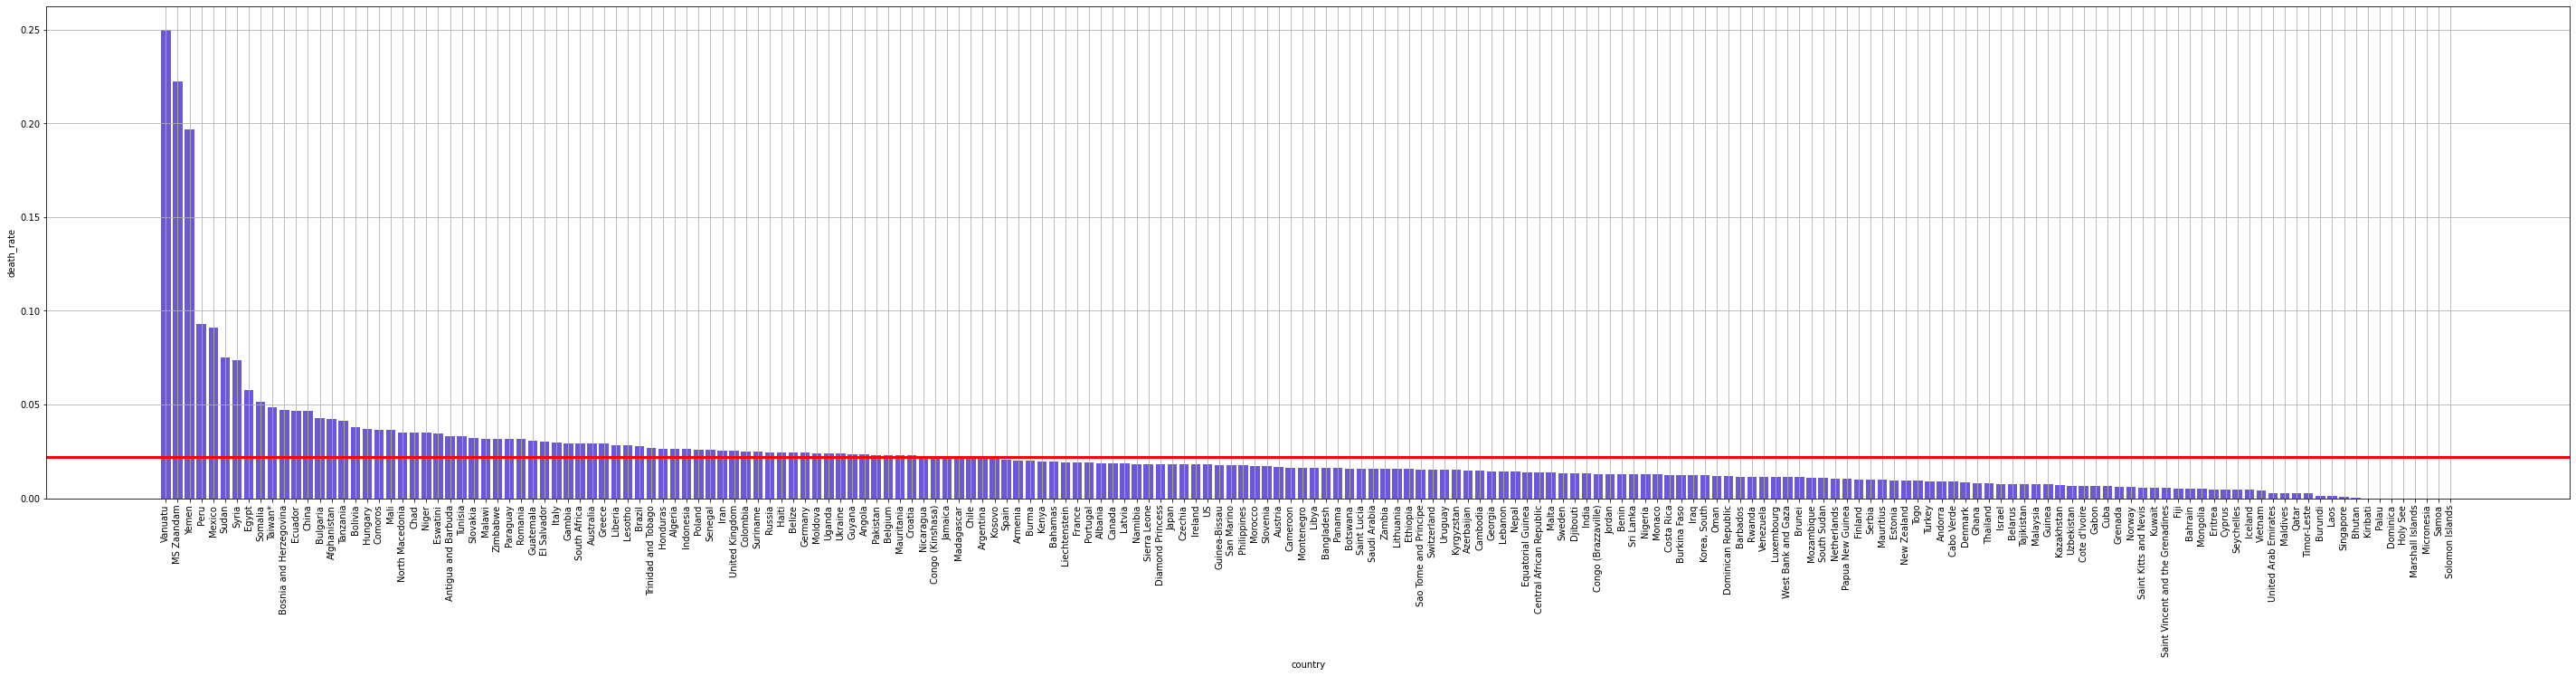

In [24]:
# 사망률을 관측한 결과, 특정 지역에서는 5% 이상의 사망률이 관측되었습니다. 
plt.figure(figsize=(50,10))
plt.bar(country_sum_df.index, country_sum_df["death_rate"], color='slateblue')

plt.xlabel("country")
plt.ylabel("death_rate")
plt.xticks(rotation=90)
plt.axhline(y=0.022, color='r', linewidth=3, label='death_rate_average')
plt.grid(True)

plt.show()

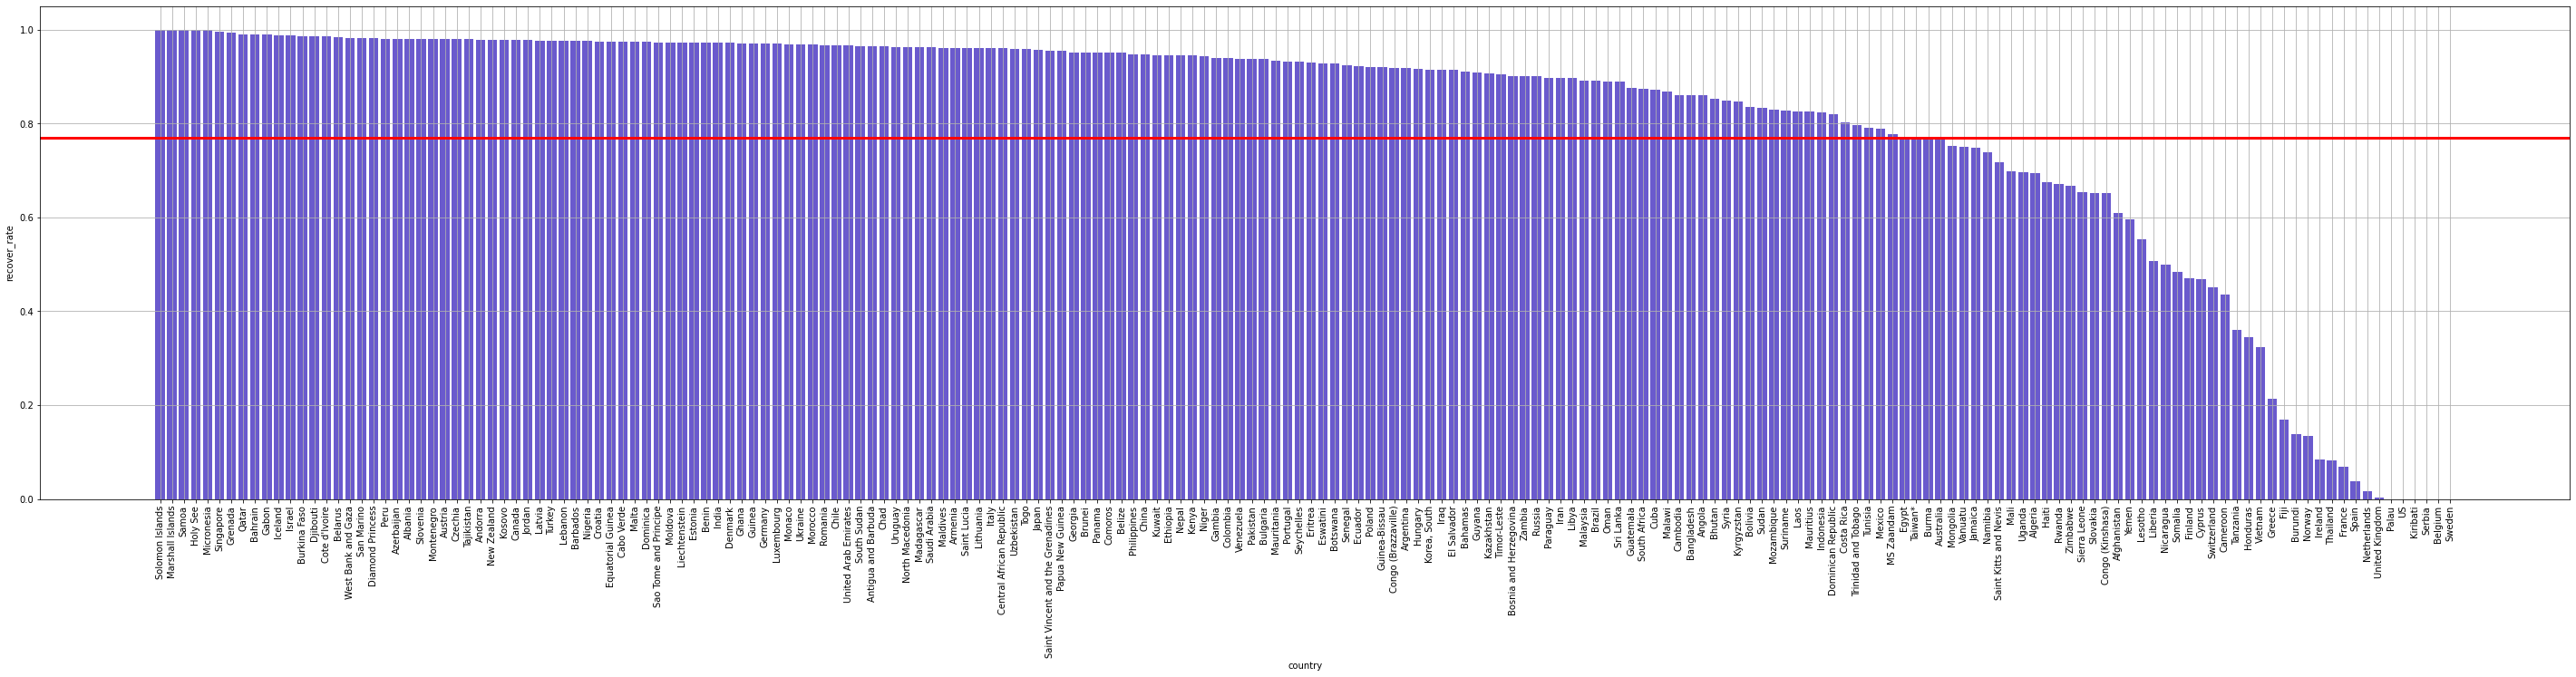

In [25]:
# 회복률을 관측한 결과, 특정 지역에서는 40% 미만이 회복되지 못하는 것을 관측할 수 있었습니다. 

df_copy = country_sum_df.copy()
df_copy = df_copy.sort_values(by=["recover_rate"], ascending=[False])

plt.figure(figsize=(50,10))
plt.bar(df_copy.index, df_copy["recover_rate"], color='slateblue')

plt.xlabel("country")
plt.ylabel("recover_rate")
plt.xticks(rotation=90)
plt.axhline(y=0.77, color='r', linewidth=3, label='recover_rate_average')
plt.grid(True)

plt.show()

데이터를 혼합하여 분석하였고, 회복되고 있는 인원, 사망률, 회복률 feature를 추가적으로 생성하였습니다.  

백신을 나누기 위해서 최초 사망률을 기준으로 백신을 분포하려고 하였으나, 미국, 영국 등 인구수가 많은 경우, 사망률은 높게 측정되어 이미 충분히 백신 접종이 이루어지고 있는 나라들이 선택될 수 있습니다. 이에, 사망률과 회복률을 모두  사용하여 어느 나라에 백신을 공급해야할지 정하도록 하겠습니다.  

In [26]:
death_rate_mean = np.round(country_sum_df.describe().T.iloc[4, 1], 3)
recover_rate_mean = np.round(country_sum_df.describe().T.iloc[5, 1], 3)

death_rate_mean, recover_rate_mean

(0.022, 0.812)

In [27]:
# 사망률의 Q1 계산하기 
# 데이터 오류 수정 후, 사망률 Q1은 변동 없습니다. 
death_rate_mean_Q1 = np.round(death_rate_mean-(death_rate_mean*0.15), 3)
print("사망률 Q1 :", death_rate_mean_Q1)

# 회복률의 Q1 계산하기 
# 데이터 오류 수정 후, 회복률 Q1이 0.655 -> 0.69로 소복 상승하였습니다. 
recover_rate_mean_Q1 = np.round(recover_rate_mean-(recover_rate_mean*0.15), 3)
print("회복률 Q1 :", recover_rate_mean_Q1)

사망률 Q1 : 0.019
회복률 Q1 : 0.69


위 그래프를 기준으로 사망률 Q1(1.9%) 보다 사망률이 높고, 회복률 평균(65%)보다 회복률이 낮은 나라에 우선적으로 백신을 공급하는 기준을 세웠고, 이 기준에 맞추어 나라를 정렬한 결과가 아래와 같습니다. 

이 나라들의 사망률을 기준으로 하여 백신을 지급받을 비율을 산출하였습니다. 
산출된 백신을 지급받을 비율과 확진자 수를 곱하여서 지급할 백신의 수를 계산하였습니다. 

계산한 결과, Yemen, MS Zaandam, Somalia, Tanzania united Kingdom에 지급하면 약 100만개의 백신이 소진됩니다. 

이후 지급되는 나라들은 벨기에 등 유럽 국가들로 자국에서 충분한 방역 조치가 이루어지고 있는 나라들입니다. 방역이 잘 이루어지고 있는 나라들에게 백신이 추가 보급될 것을 우려하여, 사망률과 회복률 지표를 함께 사용하여 백신을 지급할 나라를 선별하였습니다. 



In [28]:
# 기존 사망률Q1, 회복률Q1을 적용하였을 때 백신을 보급받는 나라 (16개국) -> 단 백신이 남는 현상이 발생됨 
condition = (country_sum_df["death_rate"] > death_rate_mean_Q1) & (country_sum_df["recover_rate"] < recover_rate_mean_Q1)
country_condition_df = country_sum_df[condition].sort_values(by=["death_rate", "recover_rate"], ascending=[False, True])

country_condition_df["백신지급비율"] = country_sum_df["death_rate"] / country_sum_df["death_rate"].sum()
country_condition_df["나라별 백신지급 수량"] = country_condition_df["confirmed"] * country_condition_df["백신지급비율"] 
country_condition_df["총 필요한 백신 수"] = country_condition_df["나라별 백신지급 수량"].cumsum()

country_condition_df = country_condition_df.astype({"나라별 백신지급 수량":int, "총 필요한 백신 수":int})
country_condition_df

,confirmed,deaths,recovered,healing,death_rate,recover_rate,백신지급비율,나라별 백신지급 수량,총 필요한 백신 수
Country/Region,,,,,,,,,
Yemen,6941,1366,4135,1440,0.19680,0.59574,0.04569,317,317
Somalia,14995,775,7252,6968,0.05168,0.48363,0.01200,179,497
Afghanistan,131586,5561,80226,45799,0.04226,0.60968,0.00981,1291,1788
Tanzania,509,21,183,305,0.04126,0.35953,0.00958,4,1793
Slovakia,391893,12519,255300,124074,0.03194,0.65145,0.00742,2906,4699
Zimbabwe,66853,2126,44580,20147,0.03180,0.66684,0.00738,493,5193
Greece,437345,12763,93764,330818,0.02918,0.21439,0.00678,2963,8156
Liberia,5102,144,2588,2370,0.02822,0.50725,0.00655,33,8189
Lesotho,11903,335,6593,4975,0.02814,0.55389,0.00653,77,8267


In [29]:
# 사망률Q1 조건만 적용하였을 때 백신을 보급 받는 나라 (21개국)
condition = (country_sum_df["death_rate"] > death_rate_mean_Q1)
country_condition_df = country_sum_df[condition].sort_values(by=["death_rate", "recover_rate"], ascending=[False, True])

country_condition_df["백신지급비율"] = country_sum_df["death_rate"] / country_sum_df["death_rate"].sum()
country_condition_df["나라별 백신지급 수량"] = country_condition_df["confirmed"] * country_condition_df["백신지급비율"] 
country_condition_df["총 필요한 백신 수"] = country_condition_df["나라별 백신지급 수량"].cumsum()
country_condition_df = country_condition_df.astype({"나라별 백신지급 수량":int, "총 필요한 백신 수":int})
country_condition_df.head(21)

,confirmed,deaths,recovered,healing,death_rate,recover_rate,백신지급비율,나라별 백신지급 수량,총 필요한 백신 수
Country/Region,,,,,,,,,
Vanuatu,4,1,3,0,0.25000,0.75000,0.05804,0,0
MS Zaandam,9,2,7,0,0.22222,0.77778,0.05159,0,0
Yemen,6941,1366,4135,1440,0.19680,0.59574,0.04569,317,317
Peru,2078815,193230,2039864,0,0.09295,0.98126,0.02158,44862,45180
Mexico,2586721,234907,2041418,310396,0.09081,0.78919,0.02108,54538,99718
Sudan,36805,2760,30647,3398,0.07499,0.83269,0.01741,640,100359
Syria,25766,1896,21876,1994,0.07359,0.84903,0.01708,440,100799
Egypt,282985,16383,217756,48846,0.05789,0.76950,0.01344,3803,104603
Somalia,14995,775,7252,6968,0.05168,0.48363,0.01200,179,104783


### 3) What is the expected impact of the vaccine? 

#### 백신 분배 후 사망률 계산

In [30]:
# 백신접종 전 확진자, 사망자, 회복자 합계 
country_sum_df["confirmed"].sum(), country_sum_df["deaths"].sum(), country_sum_df["recovered"].sum()

(186459993, 4024998, 122867840)

In [31]:
# # 백신접종 후 확진자, 사망자, 회복자 합계 (사전에, 백신을 접종한 사람은 사망하지 않는다고 가정함) / 백만개를 가지고 2번 접종을 해야하니 백신접종을 받을 수 있는 사람은 오십만명입니다. 
country_sum_df["confirmed"].sum(), country_sum_df["deaths"].sum()-500000, country_sum_df["recovered"].sum()

(186459993, 3524998, 122867840)

In [32]:
vacine_before_death_rate = np.round((country_sum_df["deaths"].sum() /country_sum_df["confirmed"].sum())*100, 3)
print(f"백신을 접종하기 전의 사망률은 {vacine_before_death_rate}% 입니다.")

백신을 접종하기 전의 사망률은 2.159% 입니다.


In [33]:
vacine_after_death_rate =  np.round(((country_sum_df["deaths"].sum()-500000) / country_sum_df["confirmed"].sum())*100, 3)
print(f"백신을 접종한 후 사망률은 {vacine_after_death_rate}% 입니다.")

백신을 접종한 후 사망률은 1.89% 입니다.


In [34]:
country_sum_df = country_sum_df.reset_index()
country_sum_df = country_sum_df.rename(columns={"Country/Region": "country"})
country_sum_df.head(2)

,country,confirmed,deaths,recovered,healing,death_rate,recover_rate
0,Vanuatu,4,1,3,0,0.25000,0.75000
1,MS Zaandam,9,2,7,0,0.22222,0.77778


#### 백신 분배 후 사망률 계산

만약, 백신을 분배하기로 했던 나라에 사전에 백신이 들어가서 갔다고 가정하고 사망률을 비교해보도록 하겠습니다. 

In [35]:
condition = (country_sum_df["death_rate"] > death_rate_mean_Q1) & (country_sum_df["recover_rate"] < recover_rate_mean_Q1)
country_condition_df = country_sum_df[condition].sort_values(by=["death_rate", "recover_rate"], ascending=[False, True])

country_condition_df["백신지급비율"] = country_sum_df["death_rate"] / country_sum_df["death_rate"].sum()
country_condition_df["나라별 백신지급 수량"] = country_condition_df["confirmed"] * country_condition_df["백신지급비율"] 
country_condition_df["총 필요한 백신 수"] = country_condition_df["나라별 백신지급 수량"].cumsum()

country_condition_df = country_condition_df.astype({"나라별 백신지급 수량":int, "총 필요한 백신 수":int})

# 선정된 나라에서 백신 수 만큼 사망자를 제외하여 사망률을 다시 계산하고자 합니다. 
country_condition_df["deaths"] = country_condition_df["deaths"] - country_condition_df["나라별 백신지급 수량"]

country_condition_df.drop(columns=["백신지급비율",	"나라별 백신지급 수량",	"총 필요한 백신 수"])

,country,confirmed,deaths,recovered,healing,death_rate,recover_rate
2,Yemen,6941,1049,4135,1440,0.19680,0.59574
8,Somalia,14995,596,7252,6968,0.05168,0.48363
14,Afghanistan,131586,4270,80226,45799,0.04226,0.60968
15,Tanzania,509,17,183,305,0.04126,0.35953
26,Slovakia,391893,9613,255300,124074,0.03194,0.65145
28,Zimbabwe,66853,1633,44580,20147,0.03180,0.66684
37,Greece,437345,9800,93764,330818,0.02918,0.21439
38,Liberia,5102,111,2588,2370,0.02822,0.50725
39,Lesotho,11903,258,6593,4975,0.02814,0.55389
42,Honduras,273702,5567,94243,172209,0.02649,0.34433


In [36]:
vacine_before_death_rate = np.round((country_condition_df["deaths"].sum() /country_condition_df["confirmed"].sum())*100, 3)
print(f"백신을 사전에 보유하고 있었다면 {vacine_before_death_rate}% 입니다.")

백신을 사전에 보유하고 있었다면 1.857% 입니다.


#### 각 데이터프레임별 시각화

In [37]:
country_sum_df = country_sum_df.set_index("country")

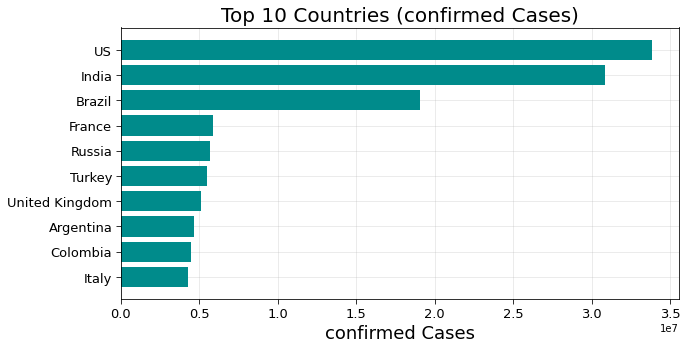

In [38]:
f = plt.figure(figsize=(10,5))


plt.axes(axisbelow=True)
plt.barh(country_sum_df.sort_values('confirmed')["confirmed"].index[-10:],country_sum_df.sort_values('confirmed')["confirmed"].values[-10:],color="darkcyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("confirmed Cases",fontsize=18)
plt.title("Top 10 Countries (confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)


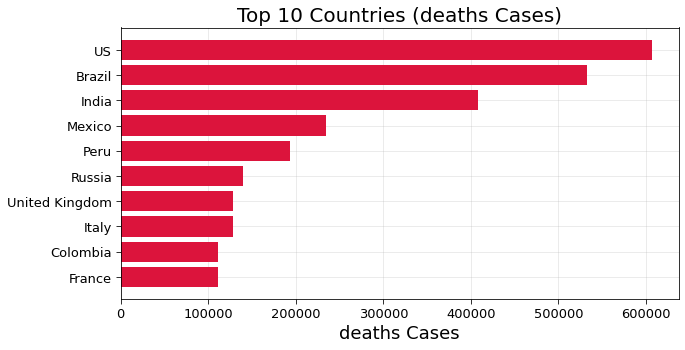

In [39]:
f = plt.figure(figsize=(10,5))

plt.axes(axisbelow=True)
plt.barh(country_sum_df.sort_values('deaths')["deaths"].index[-10:],country_sum_df.sort_values('deaths')["deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("deaths Cases",fontsize=18)
plt.title("Top 10 Countries (deaths Cases)",fontsize=20)
plt.grid(alpha=0.3)

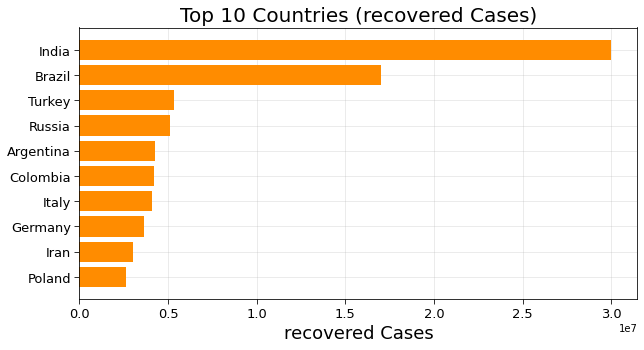

In [40]:
f = plt.figure(figsize=(10,5))

plt.axes(axisbelow=True)
plt.barh(country_sum_df.sort_values('recovered')["recovered"].index[-10:],country_sum_df.sort_values('recovered')["recovered"].values[-10:],color="darkorange")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("recovered Cases",fontsize=18)
plt.title("Top 10 Countries (recovered Cases)",fontsize=20)
plt.grid(alpha=0.3)

In [41]:
# 각각의 feature간의 상관관계가 궁금하여 확인해 보았습니다. 
country_sum_df.iloc[:,:].corr()

,confirmed,deaths,recovered,healing,death_rate,recover_rate
confirmed,1.00000,0.93103,0.72858,0.69310,-0.00556,-0.15264
deaths,0.93103,1.00000,0.66979,0.65116,0.07590,-0.14013
recovered,0.72858,0.66979,1.00000,0.01128,0.00220,0.10549
healing,0.69310,0.65116,0.01128,1.00000,-0.01199,-0.33383
death_rate,-0.00556,0.07590,0.00220,-0.01199,1.00000,-0.04070
recover_rate,-0.15264,-0.14013,0.10549,-0.33383,-0.04070,1.00000


In [42]:
# 잘 정리된 데이터를 활용하여 시각화 및 데이터를 간결하게 찾을 수 있는 함수를 2개 구현해보았습니다. 
df = pd.read_csv("daily_report.csv")
totals_df = df[["Confirmed", "Deaths", "Recovered"]].sum().reset_index(name="count")
totals_df = totals_df.rename(columns={"index": "condition"})

countries_df = df[["Country_Region", "Confirmed", "Deaths", "Recovered"]]
countries_df = countries_df.fillna(0)
countries_df = (
    countries_df.groupby("Country_Region")
    .sum()
    .sort_values(by="Confirmed", ascending=False)
    .reset_index()
)

dropdown_options =countries_df.sort_values("Country_Region").reset_index()
dropdown_options = dropdown_options["Country_Region"]

# 전세계의 날짜별 확진자, 사망자, 회복자 수를 보여주는 df를 만드는 함수 
def make_global_df():
    def make_df(condition):
        df = pd.read_csv(f"time_series_covid19_{condition}_global.csv")
        df = (
            df.drop(columns=["Province/State", "Country/Region", "Lat", "Long"])
            .sum()
            .reset_index(name=condition)
        )
        df = df.rename(columns={"index": "date"})
        return df

    final_df = None
    for condition in conditions:
        condition_df = make_df(condition)
        if final_df is None:
            final_df = condition_df
        else:
            final_df = final_df.merge(condition_df)
    return final_df

# 내가 원하는 나라 이름을 넣으면 그 나라의 확진자, 사망자, 회복자 수를 보여주는 df를 만드는 함수 
def make_country_df(country):
    def make_df(condition):
        df = pd.read_csv(f"time_series_covid19_{condition}_global.csv")
        df = df.loc[df["Country/Region"] == country]
        df = (
            df.drop(columns=["Province/State", "Country/Region", "Lat", "Long"])
            .sum()
            .reset_index(name=condition)
        )
        df = df.rename(columns={"index": "date"})
        return df

    final_df = None
    for condition in conditions:
        condition_df = make_df(condition)
        if final_df is None:
            final_df = condition_df
        else:
            final_df = final_df.merge(condition_df)
    return final_df

In [43]:
# 위도와 경도 데이터를 활용하여 시각화를 진행해보았습니다. 
# 인도와 North America 부분에서 대량의 인원이 covid19에 노출된 것을 한눈에 확인할 수 있으며, 
# 유럽의 경우 좁은 지역에서 산발적으로 발생된 것을 확인할 수 있습니다. 
fig = px.scatter_geo(countries_df, 
                     template="ggplot2",
                     color="Confirmed", 
                     size="Confirmed",
                     size_max=50,
                     locations="Country_Region",
                     locationmode="country names", 
                     hover_name="Country_Region",
                     projection="natural earth",
                     )
fig.show()

In [44]:
# 각 feature를 막대그래프로도 표현해보았습니다. 

bars_graph = px.bar(
    totals_df,
    x="condition",
    y="count",
    template="plotly_dark",
    title="Total global Cases",
)
bars_graph.update_traces(marker_color=["#34495e", "#16a085", "#95a5a6"])

### 4) Can you predict confirmed/death/recovered in 3 months future? How accurate is your prediction?

#### 4-1) confirmed_df mae, mse

데이터를 확인한 결과, 확진자, 사망자, 회복자 데이터는 feature가 모두 같고 날짜별 인원 수를 구해야하기 때문에 아래와 같이 함수를 만들어 보겠습니다. 

In [46]:
conditions = ["confirmed", "deaths", "recovered"]

def make_df(condition):
  df = pd.read_csv(f"time_series_covid19_{condition}_global.csv")
  df = df.drop(columns=["Province/State", "Country/Region", "Lat", "Long"])
  j = df.shape[1] - 1
  i = 0

  # for으로 사용하여 1번 column부터 진행하려 하였으나, 2번 column 값이 변경되기에 뒤에서부터 계산해오는 방식을 사용하였습니다. 
  while i < j :
    # -1 column을 -2 column로 빼서 실확진자 수 구하기 
    df.iloc[:, j] = df.iloc[:, j] - df.iloc[:, j-1]
    j -= 1

  df = df.sum().reset_index(name=condition)
  df = df.rename(columns={"index":"date"}) 
 
  return df


final_df = None
for condition in conditions:
  condition_df = make_df(condition)
  if final_df is None:
    final_df = condition_df
  else:
    final_df = final_df.merge(condition_df)

final_df.head(2)

,date,confirmed,deaths,recovered
0,1/22/20,557,17,30
1,1/23/20,98,1,2


In [47]:
final_df[final_df.index == 474]

,date,confirmed,deaths,recovered
474,5/10/21,621829,11124,628686


In [48]:
final_df.tail()

,date,confirmed,deaths,recovered
531,7/6/21,453745,8565,327843
532,7/7/21,463849,8586,268163
533,7/8/21,481535,8845,292651
534,7/9/21,502675,8402,333992
535,7/10/21,399937,6005,410016


In [49]:
final_df.shape, 474/536

((536, 4), 0.8843283582089553)

In [50]:
final_df = final_df.set_index("date")
final_df.head(2)

,confirmed,deaths,recovered
date,,,
1/22/20,557,17,30
1/23/20,98,1,2


In [51]:
rows = 474 # 2021.05.10을 까지를 train으로 활용하여 2021.07.10을 예측해보고자 합니다. 

In [84]:
y_test = final_df.iloc[rows:, 0]
y_train = final_df.iloc[:rows, 0]

y_train.shape, y_test.shape

((474,), (62,))

In [85]:
# 데이터 컬럼 선정 
y_train = final_df.iloc[rows:, 0]
y_test = final_df.iloc[:rows, 0]

# 확진자 수 
y_train = np.log10(np.asarray(y_train).astype("float32"))
y_test = np.log10(np.asarray(y_test).astype("float32"))

# 일수
X_train = np.arange(1, len(y_train)+1)
X_test  = np.arange(1, len(y_test)+1)

In [86]:
def build_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[1]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [87]:
model1 = build_model()
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 10,625
Trainable params: 10,625
Non-trainable params: 0
_________________________________________________________________


In [88]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model1.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [89]:
model1.save('confirmed_date_df.h5')
model1 = models.load_model("confirmed_date_df.h5")
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 10,625
Trainable params: 10,625
Non-trainable params: 0
_________________________________________________________________


In [90]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.32756,0.53562,0.32756,0.04740,0.19301,0.04740,995
996,0.28530,0.44142,0.28530,0.16719,0.38353,0.16719,996
997,0.06280,0.20415,0.06280,0.33039,0.55461,0.33039,997
998,0.02536,0.12687,0.02536,0.33372,0.55769,0.33372,998
999,0.01553,0.09528,0.01553,0.25718,0.48557,0.25718,999


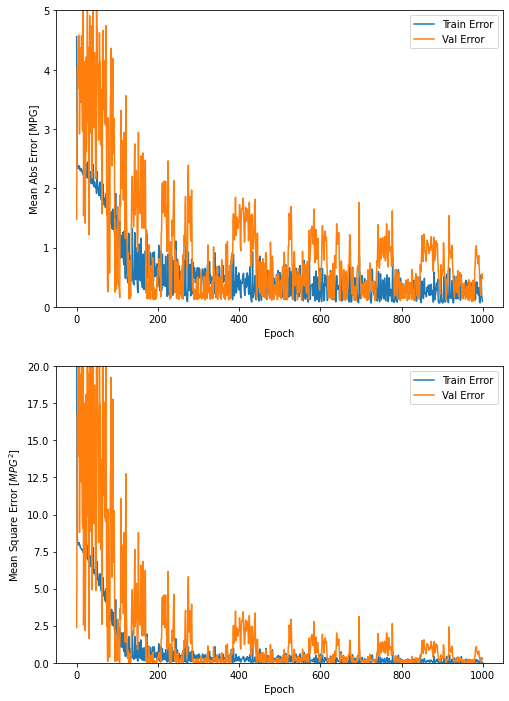

In [91]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

In [92]:
loss, mae, mse = model1.evaluate(X_test, y_test, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f}".format(mae))
print("테스트 세트의 평균 절대 오차: {:5.2f}".format(mse))

15/15 - 0s - loss: 113.0544 - mae: 9.1432 - mse: 113.0544
테스트 세트의 평균 절대 오차:  9.14
테스트 세트의 평균 절대 오차: 113.05


#### 4-2) deaths_df mae, mse

In [61]:
final_df.head(2)

,confirmed,deaths,recovered
date,,,
1/22/20,557,17,30
1/23/20,98,1,2


In [62]:
final_df.isnull().sum()

confirmed    0
deaths       0
recovered    0
dtype: int64

In [93]:
# 데이터 컬럼 선정 
y_test = final_df.iloc[rows:, 1]
y_train = final_df.iloc[:rows, 1]

# 확진자 수 
y_train = np.log10(np.asarray(y_train).astype("float32"))
y_test = np.log10(np.asarray(y_test).astype("float32"))

# 일수
X_train = np.arange(1, len(y_train)+1)
X_test  = np.arange(1, len(y_test)+1)

In [94]:
def build_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[1]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [95]:
model2 = build_model()
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 10,625
Trainable params: 10,625
Non-trainable params: 0
_________________________________________________________________


In [96]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model2.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [97]:
model2.save('deaths_date_df.h5')
model2 = models.load_model("deaths_date_df.h5")
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 10,625
Trainable params: 10,625
Non-trainable params: 0
_________________________________________________________________


In [98]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.02971,0.11560,0.02971,0.13699,0.35203,0.13699,995
996,0.02670,0.10902,0.02670,0.05152,0.20396,0.05152,996
997,0.02785,0.11287,0.02785,0.07517,0.25303,0.07517,997
998,0.02919,0.11310,0.02919,0.06843,0.23987,0.06843,998
999,0.03020,0.11620,0.03020,0.04564,0.19036,0.04564,999


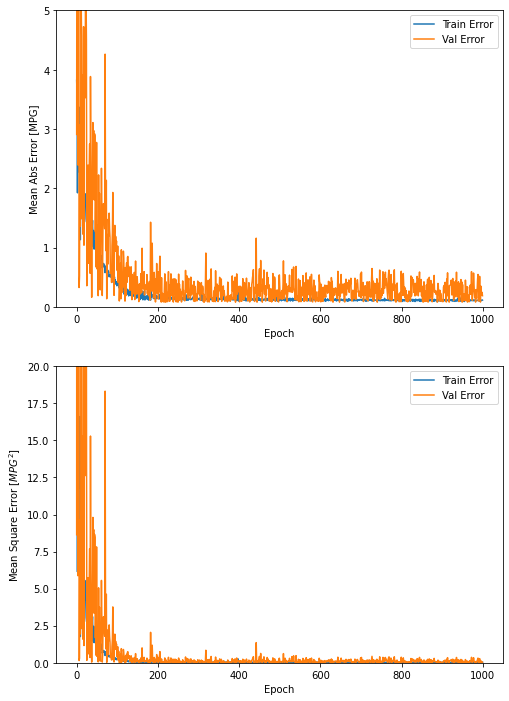

In [99]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

In [100]:
loss, mae, mse = model2.evaluate(X_test, y_test, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f}".format(mae))
print("테스트 세트의 평균 절대 오차: {:5.2f}".format(mse))

2/2 - 0s - loss: 4.4809 - mae: 2.0229 - mse: 4.4809
테스트 세트의 평균 절대 오차:  2.02
테스트 세트의 평균 절대 오차:  4.48


#### 4-3) recover_df mae, mse




In [118]:
final_df.iloc[:, 2].head(2)

date
1/22/20    30
1/23/20     2
Name: recovered, dtype: int64

In [134]:
# 데이터 컬럼 선정 
y_train = final_df.iloc[rows:, 2]
y_test = final_df.iloc[:rows, 2]

# 확진자 수 
y_train = np.log10(np.asarray(y_train).astype("float32"))
y_test = np.log10(np.asarray(y_test).astype("float32"))

# 일수
X_train = np.arange(1, len(y_train)+1)
X_test  = np.arange(1, len(y_test)+1)

In [135]:
def build_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[1]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [136]:
model3 = build_model()
model3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_34 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 33        
Total params: 10,625
Trainable params: 10,625
Non-trainable params: 0
_________________________________________________________________


In [146]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 10

history = model3.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


..........

In [147]:
# # model3.save('recovered_date_df.h5')
# # model3 = models.load_model("recovered_date_df.h5")
# model3.summary()

In [148]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.17869,0.37841,0.17869,0.36601,0.56835,0.36601,5
6,0.13056,0.31692,0.13056,0.55676,0.71426,0.55676,6
7,0.07753,0.24504,0.07753,0.18560,0.38413,0.18560,7
8,0.13940,0.33144,0.13940,0.10777,0.27763,0.10777,8
9,0.20016,0.40380,0.20016,0.13573,0.31672,0.13573,9


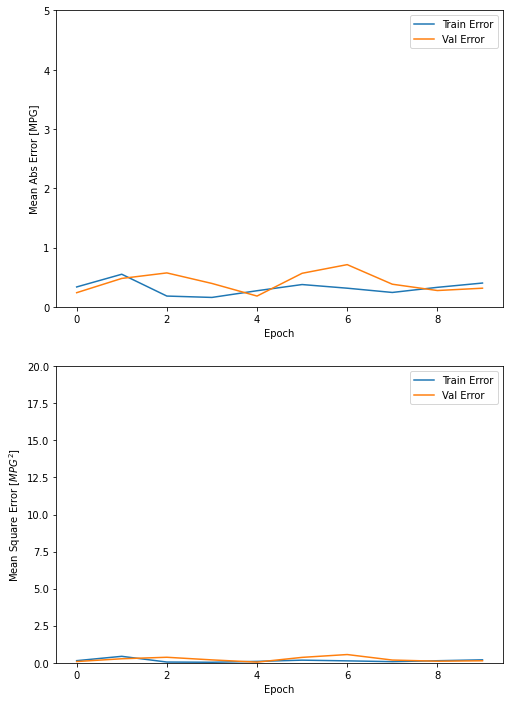

In [149]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

In [ ]:
y_test

In [152]:
loss, mae, mse = model3.evaluate(X_test, y_test, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f}".format(mae))
print("테스트 세트의 평균 절대 오차: {:5.2f}".format(mse))

15/15 - 0s - loss: nan - mae: nan - mse: nan
테스트 세트의 평균 절대 오차:   nan
테스트 세트의 평균 절대 오차:   nan


 - 해당 문제는 회귀 문제로써, mae, mse를 활용하여 딥러닝을 문제를 풀었습니다. 
 - confirmed model
  * MAE : 7.47
  * MSE : 76.10
 - deaths model
  * MAE : 7.32
  * MSE : 72.13
 - recover model
  * MAE : 17.79 
  * MSE : 423.36

1000epoch을 훈련시켰지만, 데이터가 단순하고 1개의 feature 훈련을 시키다보니 우월한 성능이 나오진 못하였습니다. MAE, MSE를 모두 측정평가로 사용하였지만, 해당 분석에서는 실질적인 인원 차이가 얼마나 나는지를 보여주는 MAE가 더 적합하다고 생각합니다.  

이상입니다. 

감사합니다.